In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libaries

In [ ]:
%pip install torchinfo

In [ ]:
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import shutil
import torch
from torch import nn
from torchinfo import summary
import cv2
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import albumentations as A
import cv2
import zipfile
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
from time import perf_counter as timer

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns

## Data Preprocessing

**Objectives:**
Use OpenCV library to do the following preprocessing task:
1. Adaptive image sharpening,
2. Bilateral noise filtering,
3. Contrast Limited Adaptive Histogram Equalization (CLAHE), and
4. Feature extraction (shape, edges, contours).

In [ ]:
# Load the original image from the dataset /content/drive/MyDrive/Colab Notebooks/Datasets/Metal Detection Data/data/NEU Metal Surface Defects Data
image_path = '/content/drive/MyDrive/Metal Detection Data/NEU Metal Surface Defects Data/train/Crazing/Cr_98.bmp'
image = Image.open(image_path)

In [ ]:
def plot_images(images, titles=None, figsize=(10, 5)):
    n = len(images)
    if titles is None:
        titles = ['Image {}'.format(i+1) for i in range(n)]

    # Create subplots with len(images) columns
    plt.figure(figsize=figsize)

    for i, image in enumerate(images):
        plt.subplot(1, n, i + 1)


        plt.imshow(image, cmap= 'gray')
        plt.title(titles[i])
        plt.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

### Adaptive image sharpening

In [ ]:
# Adaptive image sharpening
def adaptive_sharpen(image, alpha=1.5, beta=0):
    """
    Apply adaptive image sharpening using a Gaussian filter.

    Parameters:
    - image: Input image (numpy array).
    - alpha: Sharpening factor.
    - beta: Offset value.

    Returns:
    - Sharpened image (numpy array).
    """
    blurred = cv2.GaussianBlur(image, (0, 0), 3)
    sharpened = cv2.addWeighted(image, alpha, blurred, -alpha + 1, beta)
    return sharpened


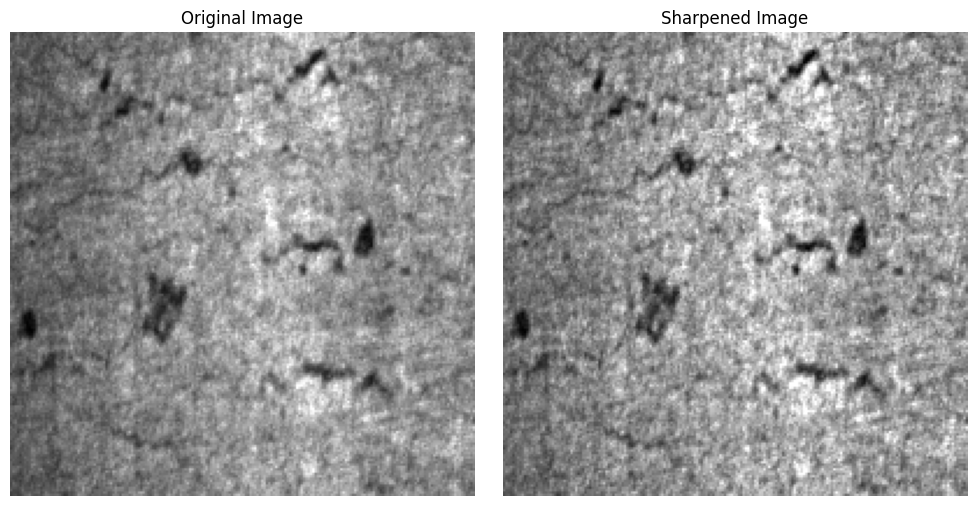

In [ ]:
image_sharpened = adaptive_sharpen(np.array(image))

# Plot the original and sharpened images side by side
plot_images([image, Image.fromarray(image_sharpened)], titles=["Original Image", "Sharpened Image"])

### Bilateral filtering

In [ ]:
def bilateral_filtering(image):

    """Filter the image using a bilateral filter."""
    # Apply bilateral filter
    filtered_image = cv2.bilateralFilter(image, d=5, sigmaColor=25, sigmaSpace=75)

    return filtered_image


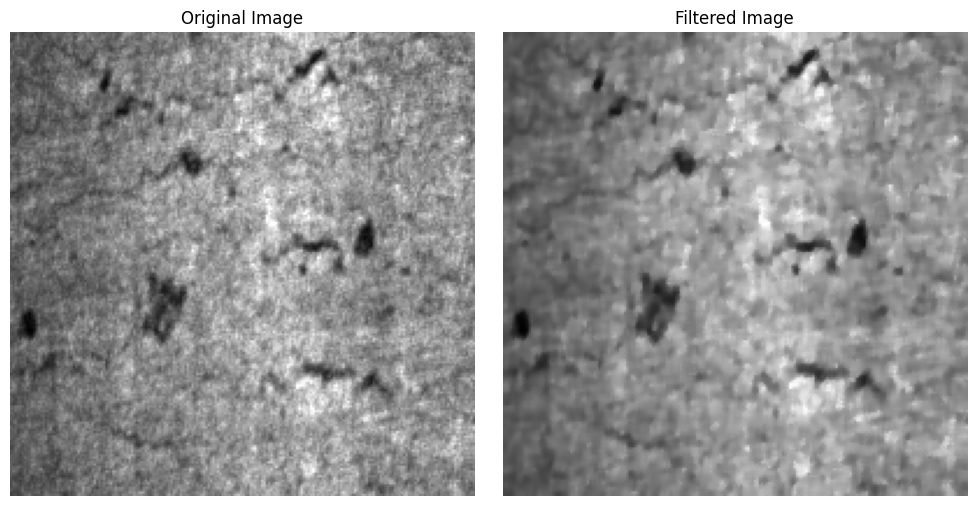

In [ ]:
image_filter = bilateral_filtering(np.array(image))

# Plot the original and minimally processed images side by side
plot_images([image, Image.fromarray(image_filter)], titles=["Original Image", "Filtered Image"])

### CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [ ]:
def apply_clahe(image):
    """
    Apply CLAHE to enhance the contrast of the image.

    Parameters:
    - image: Input image (numpy array).

    Returns:
    - CLAHE enhanced image (numpy array).
    """

    if len(image.shape) == 3:  # Check if the image is colored
        grays = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grays = image

    # Create a CLACHE object and add it to the image
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    clache_image = clahe.apply(grays)
    return clache_image

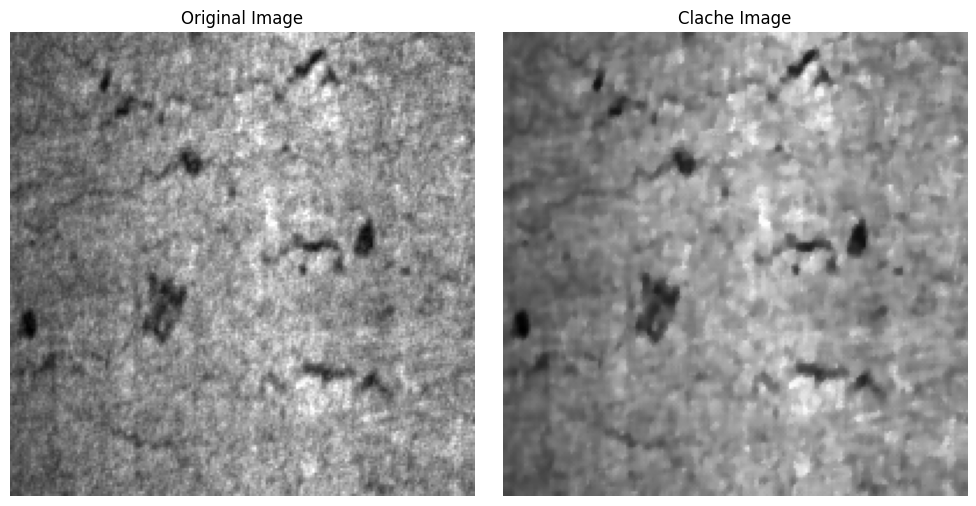

In [ ]:
mage_filter = apply_clahe(np.array(image))

# Plot the original and minimally processed images side by side
plot_images([image, Image.fromarray(image_filter)], titles=["Original Image", "Clache Image"])

### Feature Extraction (Shapes, edges and Contours)

In [ ]:
def detect_edges(image):
    # Check if image is already grayscale
    if len(image.shape) == 2 or image.shape[2] == 1:
        gray = image if len(image.shape) == 2 else image.squeeze()
    else:
        # Convert BGR/RGB to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    return edges

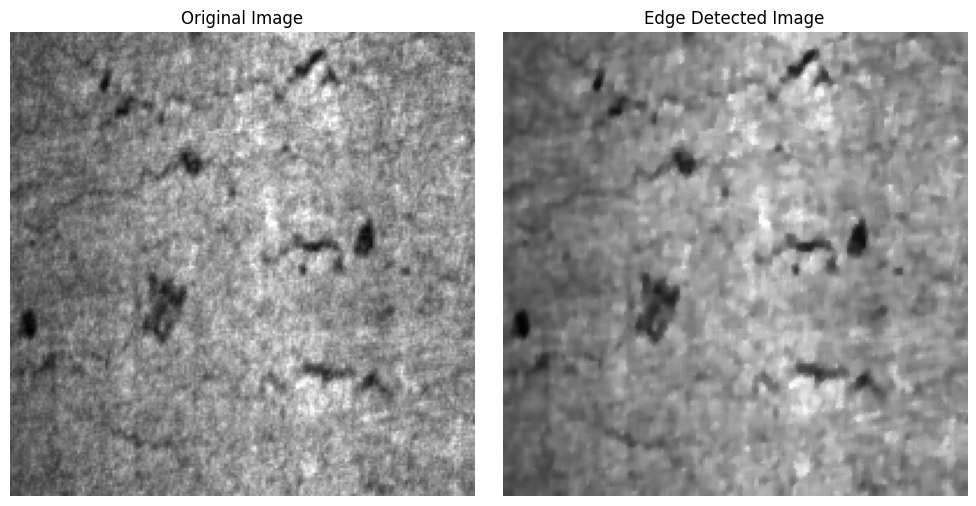

In [ ]:
mage_filter = detect_edges(np.array(image))

# Plot the original and minimally processed images side by side
plot_images([image, Image.fromarray(image_filter)], titles=["Original Image", "Edge Detected Image"])

In [ ]:
def extract_contours(image):
    """Extract contours from an image, handling both color and grayscale inputs."""
    # Check if image is already grayscale
    if len(image.shape) == 2:
        gray = image
    elif len(image.shape) == 3:
        if image.shape[2] == 1:
            gray = image.squeeze()  # Remove single channel dimension
        else:
            # Convert BGR/RGB to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError(f"Unsupported image shape: {image.shape}")

    # # Ensure the image is uint8 type
    # if gray.dtype != np.uint8:
    #     gray = gray.astype(np.uint8)

    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

In [ ]:
def preprocess_image(image):
    # Apply adaptive sharpening
    image_sharpened = adaptive_sharpen(image)

    # Apply CLAHE
    clahe_image = apply_clahe(image)

    # Detect edges using Canny
    edges = detect_edges(image)

    # Extract contours
    contours = extract_contours(image)

    # Return all results: sharpened, CLAHE, edges, contours
    return image_sharpened, clahe_image, edges, contours

In [ ]:
def compare_preprocessing_steps(image):
    """
    Compare all preprocessing steps using the existing preprocess_image function.
    """
    # Convert PIL to numpy if needed
    if hasattr(image, 'convert'):
        image_array = np.array(image)
    else:
        image_array = image

    # Use the existing preprocess_image function to get all results
    sharpened_image, clahe_image, edges_image, contours = preprocess_image(image_array)

    # Create contour visualization
    contour_mask = np.zeros(image_array.shape[:2], dtype=np.uint8)
    cv2.drawContours(contour_mask, contours, -1, 255, 2)

    # Plot all preprocessing steps
    plt.figure(figsize=(15, 8))

    # Original Image
    plt.subplot(2, 3, 1)
    if hasattr(image, 'convert'):
        plt.imshow(image, cmap='gray')
    else:
        if len(image_array.shape) == 3:
            plt.imshow(cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(image_array, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Sharpened Image
    plt.subplot(2, 3, 2)
    if len(sharpened_image.shape) == 3:
        plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(sharpened_image, cmap='gray')
    plt.title('Adaptive Sharpening')
    plt.axis('off')

    # CLAHE Image
    plt.subplot(2, 3, 3)
    plt.imshow(clahe_image, cmap='gray')
    plt.title('CLAHE Applied')
    plt.axis('off')

    # Edges Detected
    plt.subplot(2, 3, 4)
    plt.imshow(edges_image, cmap='gray')
    plt.title('Edges Detected (Canny)')
    plt.axis('off')

    # Contours Visualization
    plt.subplot(2, 3, 5)
    plt.imshow(contour_mask, cmap='gray')
    plt.title('Contours Extracted')
    plt.axis('off')

    # Sequential combination: Sharpen → CLAHE
    combined_image = adaptive_sharpen(image_array)
    combined_image = apply_clahe(combined_image)

    plt.subplot(2, 3, 6)
    if len(combined_image.shape) == 3:
        plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(combined_image, cmap='gray')
    plt.title('Combined: Sharpen + CLAHE')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Found {len(contours)} contours in the image")

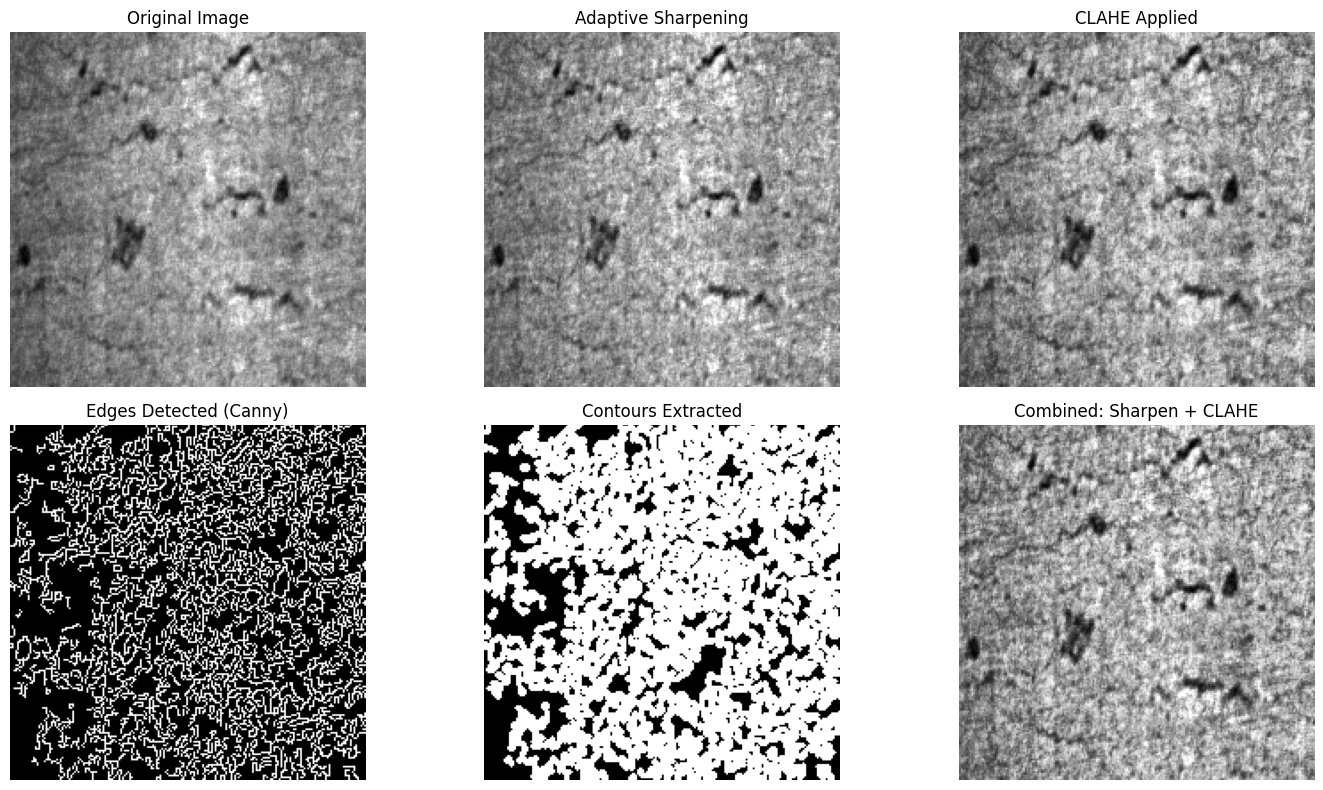

Found 320 contours in the image


In [ ]:
compare_preprocessing_steps(np.array(image))

We can observe that for this metal surface defect classification, the pre-process method we can use is only these two:
1. **Adaptive Sharpening** - to enhance defect edges
2. **CLAHE** - for contrast enhancement

### Let's Use both Sharpening and Clahe Preprocessing for our Data

In [ ]:

def preprocess_dataset(input_dir, output_dir, steps=['sharpen', 'clahe']):
    """
    Apply preprocessing steps to entire dataset.

    Parameters:
    - input_dir: Path to input dataset directory
    - output_dir: Path to save preprocessed images
    - steps: List of preprocessing steps to apply ['sharpen', 'clahe']
    """

    # Create output directory if it doesn't exist
    if os.path.exists(output_dir):
        print(f"⚠️  Output directory '{output_dir}' already exists.")
        return
        #shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory created: {output_dir}")

    # Available preprocessing functions
    step_functions = {
        'sharpen': adaptive_sharpen,
        'clahe': apply_clahe
        #'edges': detect_edges,
        #'contours': extract_contours
    }

    processed_count = 0

    # Walk through all subdirectories and files
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                # Construct paths
                input_path = os.path.join(root, file)
                relative_path = os.path.relpath(input_path, input_dir)
                output_path = os.path.join(output_dir, relative_path)

                # Create output subdirectory if needed
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                try:
                    # Load image
                    image = Image.open(input_path)
                    image_array = np.array(image)

                    # Apply selected preprocessing steps sequentially
                    processed_image = image_array.copy()

                    for step in steps:
                        if step in step_functions and step not in ['edges', 'contours']:
                            processed_image = step_functions[step](processed_image)

                    # Save processed image
                    processed_pil = Image.fromarray(processed_image)
                    processed_pil.save(output_path)
                    processed_count += 1

                    if processed_count % 100 == 0:
                        print(f"Processed {processed_count} images...")

                except Exception as e:
                    print(f"Error processing {input_path}: {str(e)}")

    print(f"Preprocessing complete! Processed {processed_count} images.")
    print(f"Applied steps: {' + '.join(steps)}")
    print(f"Output saved to: {output_dir}")


In [ ]:
# # Apply adaptive sharpening + CLAHE to entire dataset
# input_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Metal Detection Data/NEU Metal Surface Defects Data"
# output_dataset_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Metal Detection Data/Processed_Data"

# preprocess_dataset(input_dataset_path, output_dataset_path, steps=['sharpen', 'clahe'])

Output directory created: /content/drive/MyDrive/Colab Notebooks/Datasets/Metal Detection Data/Processed_Data
Preprocessing complete! Processed 0 images.
Applied steps: sharpen + clahe
Output saved to: /content/drive/MyDrive/Colab Notebooks/Datasets/Metal Detection Data/Processed_Data


## Transform Data and Create Dataloader and Plot More Data Samples

In [ ]:
# Load the dataset
train_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/train"
valid_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/valid"
test_data_path = "/content/drive/MyDrive/Metal Detection Data/Processed_Data/test"

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure images are 3-channel (RGB)
    transforms.Resize((256, 256)),  # Resize to a common size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load the dataset
train_data = datasets.ImageFolder(train_data_path, transform=transform)
valid_data = datasets.ImageFolder(valid_data_path, transform=transform)
test_data = datasets.ImageFolder(test_data_path, transform=transform)

# Create DataLoader for batching and shuffling
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
class_names= train_data.classes
class_dict= train_data.class_to_idx

class_names, class_dict

(['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches'],
 {'Crazing': 0,
  'Inclusion': 1,
  'Patches': 2,
  'Pitted': 3,
  'Rolled': 4,
  'Scratches': 5})

In [ ]:
# Get the shape of training data
train_num, train_shape = len(train_data), train_data[0][0].shape
print(f"Number of training samples: {train_num}, Shape: {train_shape}")

Number of training samples: 1666, Shape: torch.Size([3, 256, 256])


In [ ]:
# Get the shape of testing data
test_samples, test_shape = len(test_data), test_data[0][0].shape
print(f"Number of Testing samples: {test_samples}, Shape: {test_shape}")

Number of Testing samples: 72, Shape: torch.Size([3, 256, 256])


### Plot some sample of the Data

In [ ]:
def plot_image_categories(data_dir, num_images=4):
    """
    Plots the first few images from each category (subdirectory) in the data directory.
    """
    # List subdirectories (categories)
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    # Iterate over categories and display images
    for category in categories:
        category_path = os.path.join(data_dir, category)
        # Get the first 'num_images' images in each category
        images = [os.path.join(category_path, img) for img in os.listdir(category_path)[:num_images]]

        print(f"Category: {category}")
        # Plot the images
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for ax, image_path in zip(axes, images):
            img = Image.open(image_path)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.show()

Category: Scratches


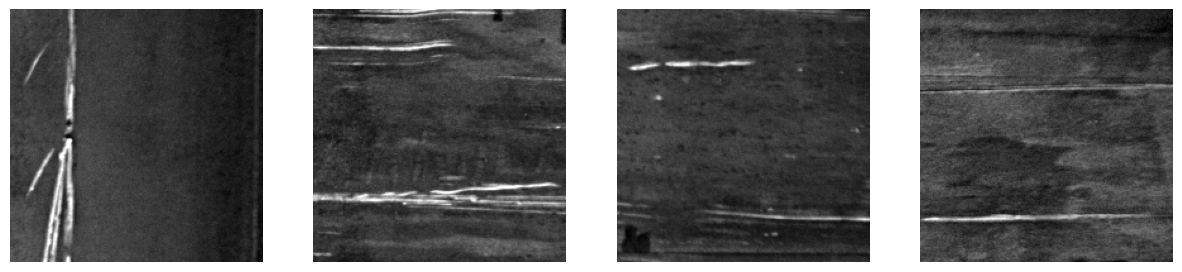

Category: Inclusion


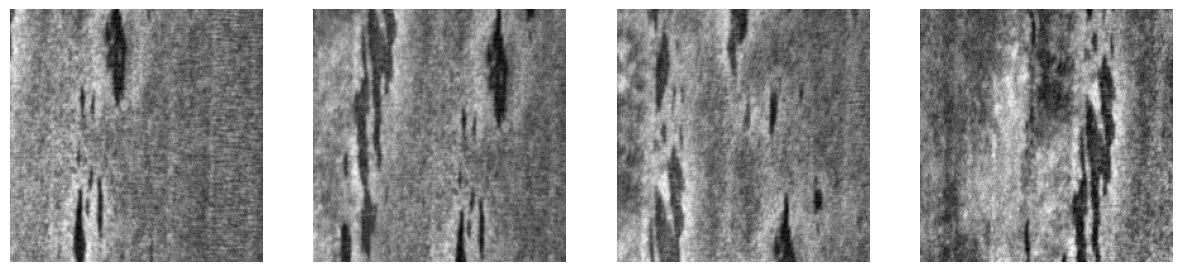

Category: Rolled


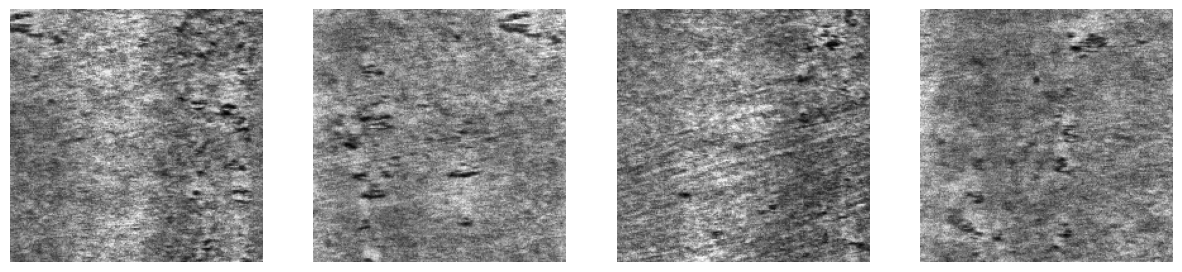

Category: Pitted


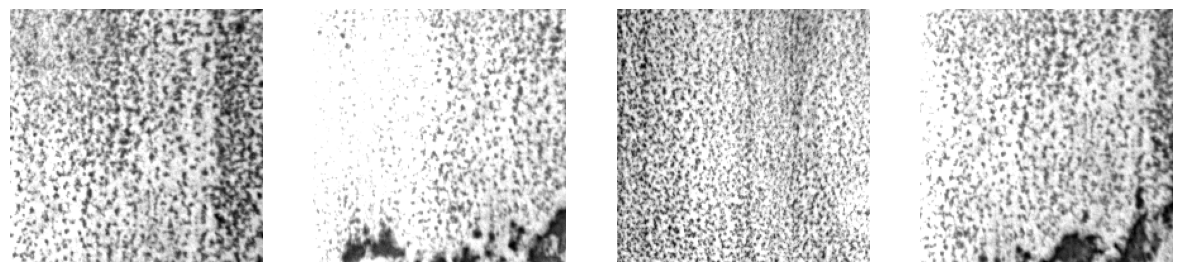

Category: Crazing


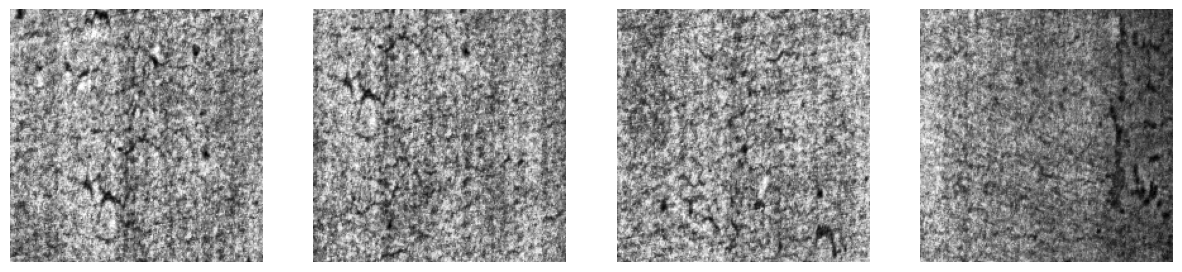

Category: Patches


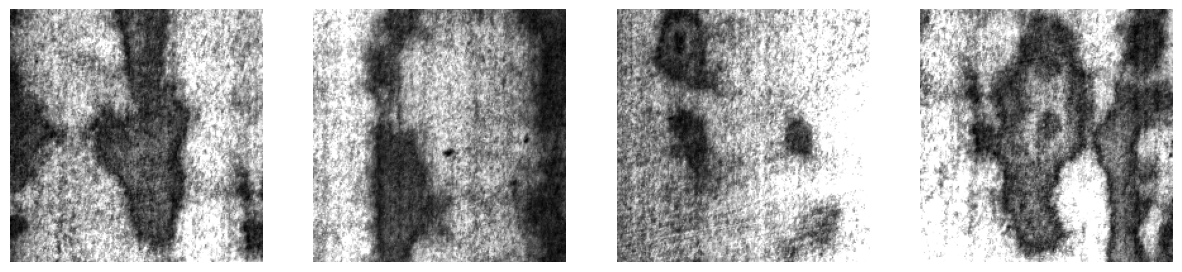

In [ ]:
plot_image_categories(train_data_path, num_images=4)